<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import itertools
from IPython.display import Image
import re
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
def safe_list_parse(df, column):
    """
    Fix a column where lists are stored as strings.
    Handles both comma-separated and space-separated formats.

    Args:
        df: pandas DataFrame
        column: str, name of the column to fix

    Returns:
        df with the specified column parsed into lists of floats
    """
    df[column] = (
        df[column]
        .astype(str)
        .str.strip('[]')
        .apply(lambda s: [float(x) for x in re.split(r'[,\s]+', s.strip()) if x])
    )
    return df

warnings.filterwarnings("ignore")

In [2]:
# @title Figure 3A (Top & Middle)
Image(url='https://github.com/yiruchen4/Chen2026/blob/main/Images/Figure%203A.png?raw=true', width=1000)

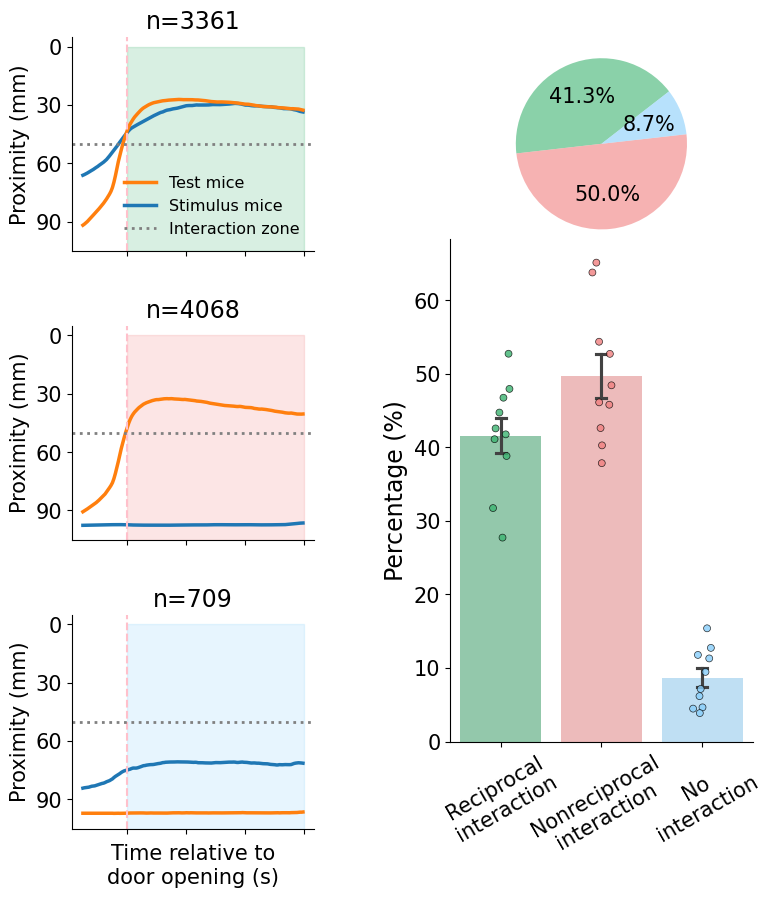

In [3]:
# @title Figure 3A-B
event_df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_Figure3.csv")

# Example: shared time axis
time_window = np.round(np.arange(-3, 12, 0.1), 2)
event_df = safe_list_parse(event_df, 'prox1_values')
event_df = safe_list_parse(event_df, 'prox2_values')
event_df = safe_list_parse(event_df, 'time_window')

desired_clusters = [0, 1, 2]
clustertitles = {0: 'Reciprocal', 1: 'Nonreciprocal', 2: 'No interaction'}
cluster_bg_color = {0: "#3CB371", 1: "#F08080", 2: "#87CEFA"}  # light backdrops

# Colors for bar/pie (no "Late interaction")
light_colors_str = {
    "Reciprocal interaction": "#3CB371",
    "Nonreciprocal interaction": "#F08080",
    "No interaction": "#87CEFA",
}

# Which column to summarize on the right side
interaction_col = 'interaction'  # change to 'behavior' if needed

# ---------- Figure layout: 3x2 ----------
fig = plt.figure(figsize=(7.4, 8.7))
gs = GridSpec(              #7
    nrows=3, ncols=2, figure=fig,
    width_ratios=[0.8, 1], height_ratios=[1, 1, 1],
    left=0.06, right=0.98, top=0.98, bottom=0.07,
    wspace=0.5, hspace=0.35
)
        #0.35
# ----- Left column: 3 stacked line plots -----
axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]
for i, cluster_num in enumerate(desired_clusters):
    ax = axes[i]

    cl_df = event_df[event_df['cluster'] == cluster_num]
    prox1_list, prox2_list = [], []
    for _, r in cl_df.iterrows():
        p1 = r.get("prox1_values", [])
        p2 = r.get("prox2_values", [])
        prox1_list.append(p1[-150:] if len(p1) else [])
        prox2_list.append(p2[-150:] if len(p2) else [])

    # Filter/stack safely
    prox1_list = [x for x in prox1_list if len(x) == 150]
    prox2_list = [x for x in prox2_list if len(x) == 150]

    n_events = 0
    if len(prox1_list) and len(prox2_list):
        arr1 = np.vstack(prox1_list).astype(float)
        arr2 = np.vstack(prox2_list).astype(float)
        n_events = arr1.shape[0]
        avg1 = np.nanmean(arr1, axis=0)  # Stimulus mice
        avg2 = np.nanmean(arr2, axis=0)  # Test mice
        ax.plot(time_window, avg1, label="Stimulus mice", lw=2.5)
        ax.plot(time_window, avg2, label="Test mice", lw=2.5)

    # Background + refs
    ax.axvline(x=0, color='pink', linestyle='--')
    ax.axhline(y=50, color='grey', linestyle=':', lw=2, label="Interaction zone")
    ax.add_patch(plt.Rectangle((0, 0), 12, 105, color=cluster_bg_color[cluster_num], alpha=0.2))

    ax.set_ylim([105, -5])  # inverted to match prior style
    ax.set_title(f'n={n_events}', fontsize=17)#{clustertitles[cluster_num]}\n(
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Proximity (mm)", fontsize=15)
    ax.tick_params(labelsize=15)

# Share x/y across left column
for ax in axes[1:]:
    ax.sharex(axes[0])
    ax.sharey(axes[0])
ax.set_xlabel("Time relative to\ndoor opening (s)", fontsize=15)
# >>> Remove x tick labels for top and middle plots <<<
for ax in axes[:-1]:   # all except bottom one
    ax.set_xticklabels([])
    ax.set_xlabel('')  # optional: also remove x-axis label

# Legend on bottom-left
handles, labels = axes[0].get_legend_handles_labels()
name_to_idx = {lab: i for i, lab in enumerate(labels)}
order = [name_to_idx.get("Test mice"), name_to_idx.get("Stimulus mice"), name_to_idx.get("Interaction zone")]
order = [i for i in order if i is not None]
if order:
    axes[0].legend([handles[i] for i in order], [labels[i] for i in order],
                    frameon=False, loc='lower right', fontsize=11.5)

# ----- Top-right: standalone pie chart -----
ax_pie = fig.add_subplot(gs[0, 1])

# Build counts for desired order (drop "Late interaction")
candidate_order = [
    'Reciprocal interaction',
    'Nonreciprocal interaction',
    'No interaction',
]
counts = event_df[interaction_col].value_counts()
counts = counts.reindex([c for c in candidate_order if c in counts.index]).dropna()

if len(counts):
    pct = counts / counts.sum() * 100
    ax_pie.pie(
        pct.values,
        colors=[light_colors_str.get(lbl, 'gray') for lbl in pct.index],
        autopct=lambda p: f"{p:.1f}%" if p >= 1 else "",
        startangle=37.8,
        textprops={'fontsize': 15, 'ha': 'center', 'va': 'center'},
        wedgeprops={'alpha': 0.6}
    )
    # ax_pie.set_title('Overall distribution', fontsize=13)
    ax_pie.set_aspect('equal')
else:
    ax_pie.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
    ax_pie.set_axis_off()

# ----- Middle+bottom-right: bar+strip spanning two rows -----
ax_bar = fig.add_subplot(gs[1:, 1])

available = event_df[interaction_col].dropna().unique().tolist()
desired_order = [lab for lab in candidate_order if lab in available]

# Per-device percentages
individual = (
    event_df.groupby(['device_number', interaction_col])
            .size().unstack(fill_value=0)
)
individual = individual.reindex(columns=desired_order, fill_value=0)
individual = individual.div(individual.sum(axis=1), axis=0) * 100  # row-wise %
interaction_reshaped = (
    individual.stack()
              .reset_index()
              .rename(columns={'level_1': 'interaction', 0: 'percentage'})
)

palette = [light_colors_str.get(lbl, 'gray') for lbl in desired_order]
sns.barplot(
    data=interaction_reshaped, x='interaction', y='percentage',
    order=desired_order, errorbar='se',
    capsize=0.1, alpha=0.6, palette=palette, ax=ax_bar
)
sns.stripplot(
    data=interaction_reshaped, x='interaction', y='percentage',
    order=desired_order, jitter=True,
    alpha=0.8, edgecolor='k', linewidth=0.5,
    palette=palette, ax=ax_bar, zorder=2
)

# Cosmetics
ax_bar.set_xlabel('')
ax_bar.set_ylabel('Percentage (%)', fontsize=17)
def wrap_if_needed(s, width=13):
    return s if len(s) <= width else textwrap.fill(s, width=width)

wrapped = [wrap_if_needed(lbl, width=13) for lbl in desired_order]
ax_bar.set_xticks(ax_bar.get_xticks(), rotation = 30
                  , labels=wrapped, fontsize = 15)
ax_bar.tick_params(axis='y', labelrotation=0, labelsize=15)
sns.despine(ax=ax_bar, top=True, right=True)
if ax_bar.legend_:
    ax_bar.legend_.set_visible(False)

# Lift the bottom-right subplot (ax_bar) upward a bit
fig.canvas.draw()  # optional, but helps ensure positions are initialized

pos = ax_bar.get_position()  # Bbox in figure coordinates
dy = 0.1                    # how much to move up (tune this)
ax_bar.set_position([pos.x0, pos.y0 + dy, pos.width, pos.height])

plt.show()

